# Model run notebook
This notebook runs the do3se model components on the data.
It consists of the below sections:

1. Import the configurations
2. Process the input data
3. Calculate the phenology from the data and parameters
4. Run the full do3se model on the data
5. Process and Analyse the results

In [3]:
DIRECTORY = "examples/multirun" # Change this to run on a differeny directory

In [4]:
# Common dependencies
from pprint import pprint
from matplotlib import pyplot as plt 
from dataclasses import asdict
from pathlib import Path
import os
import pandas as pd
import numpy as np
from typing import List

---
# 1. Load configs

In [5]:
from pyDO3SE.Config.config_loader import config_loader
from pyDO3SE.Config.Config_Shape import Config_Shape

In [6]:
config_file_names = os.listdir(f"{DIRECTORY}/configs")
configs: List[Config_Shape] = [config_loader(f"{DIRECTORY}/configs/{f}") for f in config_file_names]
pprint(asdict(configs[0]))

{'Land_Cover': {'LAI': 3,
                'LAI_method': 'constant',
                'SAI': None,
                'SAI_method': 'estimate total',
                'fLAI': array([[1.]]),
                'height_method': 'constant',
                'layer_height_frac': array([1.]),
                'nL': 1,
                'nLC': 1,
                'parameters': [{'Lm': 0.02,
                                'Y': 6.0,
                                'cosA': 0.5,
                                'gsto': {'SWP_max': -0.05,
                                         'SWP_min': -1.25,
                                         'Tleaf_method': 'ambient',
                                         'VPD_crit': 8.0,
                                         'VPD_max': 1.2,
                                         'VPD_min': 3.2,
                                         'fSWP_exp_a': 0.355,
                                         'fSWP_exp_b': -0.706,
                                         'fSWP_exp_curve

In [7]:
# TODO: Run for all configs
t_b = configs[0].Met.td_base_temperature
t_b

0

---
# 2. Load and Check the input data
We need to load the input data and run any met processes on it to align it to the required DO3SE inputs

## Load input data

In [8]:
input_file_names = os.listdir(f"{DIRECTORY}/inputs_raw")
# specify headings to ensure consist names between files
headings = [
    "mm",
    "mdd",
    "dd",
    "hr",
    "Ts_C",
    "VPD",
    "u",
    "precip,mm",
    "P,kPa",
    "O3,ppb",
    "PAR,W m-2"
]
input_data = [pd.read_csv(f"{DIRECTORY}/inputs_raw/{f}", names=headings, dtype=float, skiprows=1) for f in input_file_names]
input_data[0].head()

,mm,mdd,dd,hr,Ts_C,VPD,u,"precip,mm","P,kPa","O3,ppb","PAR,W m-2"
0,1.0,1.0,1.0,0.0,3.28,0.05699,0.52,0.03,91.86,33.904,0.0
1,1.0,1.0,1.0,1.0,3.54,0.07755,0.52,0.03,91.88,32.521,0.0
2,1.0,1.0,1.0,2.0,3.41,0.07661,0.52,0.03,91.87,31.771,0.0
3,1.0,1.0,1.0,3.0,3.09,0.06531,0.52,0.03,91.86,31.242,0.0
4,1.0,1.0,1.0,4.0,3.22,0.07418,0.50,0.03,91.86,30.818,0.0


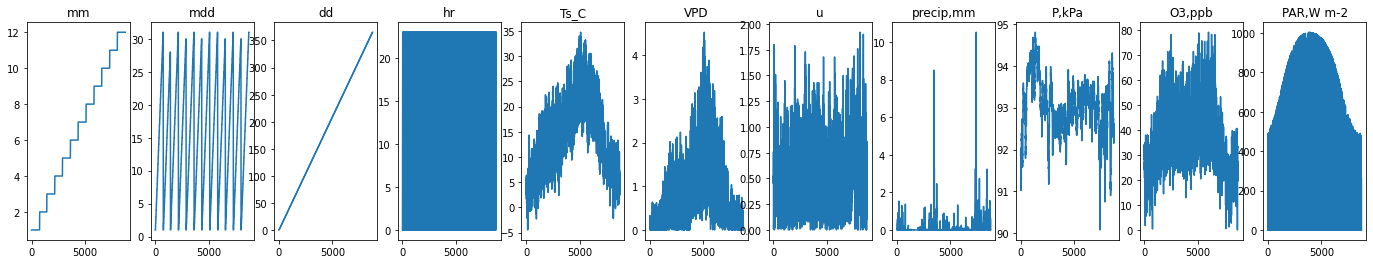

In [9]:
# Plot data from the datasets to sanity check the inputs
def plot_data(data, var, ax):
    [ax.plot(i[var]) for i in input_data]; ax.set_title(label=var)

fig, axs = plt.subplots(ncols=len(headings), figsize=(24,4))
[plot_data(input_data, headings[i], axs[i]) for i in range(len(headings))]
plt.show()


## Process input data
Data processing steps

1. convert temp to celsius
2. convert pressure to kPa
3. rename headings
4. Save out processed Data



In [10]:
from thermal_time import calcs as td_calcs

In [11]:
required_do3se_headings = {'dd', 'par', 'o3', 'precip', 'u', 'Ts_C', 'VPD', 'td', 'P', 'hr'}
def process_data(input_data_single):
    """Process input data

    Including:
    - Rename headers
    - Convert units
    - Calculate missing values


    Valid headings are located in the External_State_Shape.py file in pyDO3SE
    """
    processed_data_single = pd.DataFrame()

    
    # == Temperature setup
    # = Perform and temperature conversions here
    processed_data_single['Ts_C'] =  input_data_single['Ts_C']

    # == Add thermal time
    processed_data_single['td'] = td_calcs.calc_thermal_time_range(processed_data_single['Ts_C'], t_b)

    # == Convert Pressures
    processed_data_single['P'] = input_data_single['P,kPa']
    processed_data_single['VPD'] = input_data_single['VPD']

    # == Add julian day and hours
    DAY_0 = 0 # Change if row 0 is not Jan 1st
    processed_data_single['hr'] = input_data_single['hr']
    processed_data_single['dd'] = input_data_single['dd'] if "dd" in input_data_single.columns else np.floor(input_data_single['hr'] / 24) + DAY_0
    
    # == PAR solar data
    # Convert solar data to PAR W m^2
    processed_data_single['par'] = input_data_single['PAR,W m-2']

    # == Wind data
    processed_data_single['u'] = input_data_single['u']

    # == Precip data
    processed_data_single['precip'] = input_data_single['precip,mm']

    # == Gas data
    processed_data_single['o3'] = input_data_single['O3,ppb']

    return processed_data_single

# Apply to all datasets
processed_data = list(map(process_data, input_data))
assert set(processed_data[0].columns) == required_do3se_headings
processed_data[0].head()

,Ts_C,td,P,VPD,hr,dd,par,u,precip,o3
0,3.28,3.769167,91.86,0.05699,0.0,1.0,0.0,0.52,0.03,33.904
1,3.54,3.769167,91.88,0.07755,1.0,1.0,0.0,0.52,0.03,32.521
2,3.41,3.769167,91.87,0.07661,2.0,1.0,0.0,0.52,0.03,31.771
3,3.09,3.769167,91.86,0.06531,3.0,1.0,0.0,0.52,0.03,31.242
4,3.22,3.769167,91.86,0.07418,4.0,1.0,0.0,0.50,0.03,30.818


## Save processed data

In [12]:
for fname, d in zip(input_file_names, processed_data):
    d.to_csv(f"{DIRECTORY}/inputs/{fname}", index=False)

---
# 3. Get phenology for each cultivar/dataset

We can use the do3se_phenology package to estimate f_phen using thermal time interval in the config and temperature data converted to thermal time

In [13]:
from do3se_phenology.f_phen import tt_leaf_f_phen_PLF_range, tt_f_phen_simple_PLF_range
from do3se_phenology.plots import *

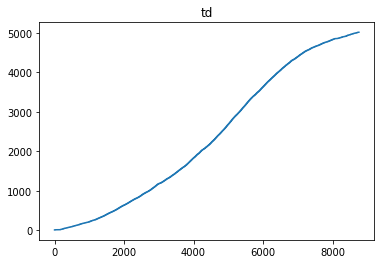

In [14]:
# Use single dataset for checking setup. Check thermal time is used.
working_data = processed_data[0]
working_data['td'].plot(title="td")
plt.show()

In [15]:
# Phenology parameters from config
ILC = 0 # Land cover index
multip_gsto_config = configs[0].Land_Cover.parameters[ILC].multip_gsto
t_leaf_f_phen_a = multip_gsto_config.t_leaf_f_phen_a
t_leaf_f_phen_b=multip_gsto_config.t_leaf_f_phen_b
t_leaf_f_phen_e=multip_gsto_config.t_leaf_f_phen_e
t_leaf_f_phen_g=multip_gsto_config.t_leaf_f_phen_g
t_leaf_f_phen_h=multip_gsto_config.t_leaf_f_phen_h
t_leaf_f_phen_i=multip_gsto_config.t_leaf_f_phen_i
t_astart = multip_gsto_config.t_astart
td_at_sgs = 0

t_f_phen_a = multip_gsto_config.t_f_phen_a
t_f_phen_b = multip_gsto_config.t_f_phen_b
t_f_phen_c = multip_gsto_config.t_f_phen_c
t_f_phen_d = multip_gsto_config.t_f_phen_d
f_phen_min = multip_gsto_config.f_phen_min

In [16]:
"""

CANOPY F PHEN
===========
        
                 
                       ______________ 1                  
                      /              \                   
                     /                \                
     <f_phen_1>  _  /                  \               
                   |                    \  _<f_phen_4>       
f_phen_min  |______|                     |             
                                         |                 
                                         |________ 0       
            |Sowing day
            |------| t_f_phen_a
            |----------| t_f_phen_b
            |-----------------------| t_f_phen_c
            |----------------------------| t_f_phen_d


LEAF F PHEN
===========
                Mid Anthesis    f
                 ____|__________/
                |              \\
                |               \\
             a  |                \\
                |<1>              <2>\  c
                |                     |
         _______|                     |________
            Astart                  Aend


        |-------| t_astart
                |----| t_leaf_f_phen_e
                     |----------| t_leaf_f_phen_g
                     |-------------| t_leaf_f_phen_h
                     |----------------| t_leaf_f_phen_i
                                      Aend

"""
leaf_f_phen_data = tt_leaf_f_phen_PLF_range(
    working_data['td'],
    t_leaf_f_phen_a=t_leaf_f_phen_a,
    t_leaf_f_phen_b=t_leaf_f_phen_b,
    t_leaf_f_phen_e=t_leaf_f_phen_e,
    t_leaf_f_phen_g=t_leaf_f_phen_g,
    t_leaf_f_phen_h=t_leaf_f_phen_h,
    t_leaf_f_phen_i=t_leaf_f_phen_i,
    t_astart=t_astart,
    td_at_sgs=td_at_sgs
)
f_phen_data = tt_f_phen_simple_PLF_range(
    working_data['td'],
    t_f_phen_a=t_f_phen_a,
    t_f_phen_b=t_f_phen_b,
    t_f_phen_c=t_f_phen_c,
    t_f_phen_d=t_f_phen_d,
    f_phen_min=f_phen_min,
    td_at_sgs=td_at_sgs,
)


<module 'matplotlib.pyplot' from '/home/ubu/source/DO3SE/pyDO3SE/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

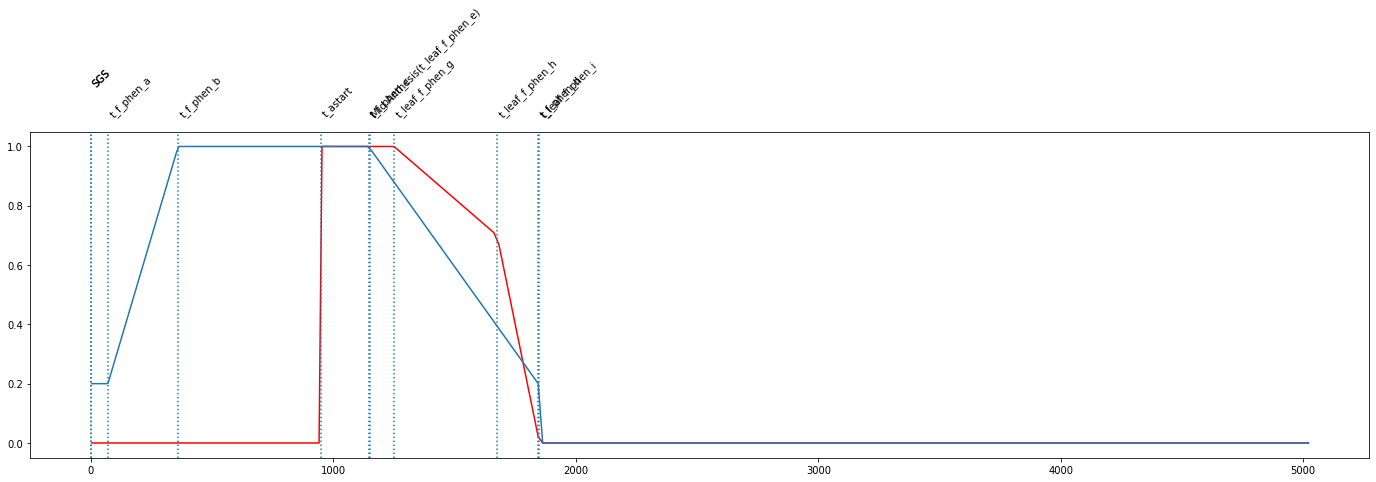

In [17]:
# Plot leaf f phen and f phen
plt.figure(figsize=(24,6))
plot_leaf_f_phen_data(
    working_data['td'],
    leaf_f_phen_data,
    t_leaf_f_phen_a,
    t_leaf_f_phen_b,
    t_leaf_f_phen_e,
    t_leaf_f_phen_g,
    t_leaf_f_phen_h,
    t_leaf_f_phen_i,
    t_astart,
    td_at_sgs,
)
plot_f_phen_data(
    accumulated_temperatures=working_data['td'],
    f_phen_data=f_phen_data,
    t_f_phen_a= t_f_phen_a,
    t_f_phen_b= t_f_phen_b,
    t_f_phen_c= t_f_phen_c,
    t_f_phen_d= t_f_phen_d,
)

## Save out updated configs

In [18]:
# TODO: Save out configs

---
# Run model

To run the model we need to load in the config and data files

In [19]:
from pyDO3SE.main import main as pyDO3SE_main # This is the primary entrypoint to the do3se model

Loading external data from examples/multirun/inputs/cell1.csv
/home/ubu/source/DO3SE/pyDO3SE/pyDO3SE/Pipelines/es_init_processes.py:355: UserWarning: max PAR is greater than 1200. Are you sure this is not PPFD?
  warnings.warn("max PAR is greater than 1200. Are you sure this is not PPFD?")
Output saved to Gsto_l-gsto_l-DEMO


72982570425467,
   'PARshade': 97.94107759693821,
   'A_n': None,
   'A_n_limit_factor': None,
   'A_n_acc': 0,
   'fst': 0,
   'fst_acc': 0.0,
   'rsto_l': 100000,
   'gsto_l': 0.0,
   'gsto': 0.0,
   'gsto_bulk': 0.0,
   'fO3_d': 1.0,
   'fO3_h': 1.0,
   'c_i': None,
   'td_dd': 0,
   'o3_ppb': 21.942367267285473,
   'o3_nmol_m3': 875.6467979297661,
   'canopy_height': 1.0,
   'o3_ppb_i': 28.6,
   'pody': 0.0,
   'pod0': 0.0,
   'precip_acc': 9e-06,
   'swp': -0.02239636114933367,
   'asw': 0.11225133838984062,
   'smd': 0.011630296901941325,
   'sn': 0.2744929374640782,
   'ei': 0.0004998344015560652,
   'et': 9.190252827864955e-07,
   'es': 0.00010939475070865116,
   'ei_acc': 0.0007848831345190375,
   'et_acc': 1.4795823976769908e-06,
   'es_acc': 0.0001521221493600601,
   'f_phen': 0.0,
   'leaf_f_phen': 0.0,
   'f_light': 0.9907840257542228,
   'leaf_f_light': 0.9999997303774988,
   'f_temp': 0.01,
   'f_VPD': 1.0,
   'f_SW': 1.0,
   'f_O3': 1.0,
   'ustar': 0.08583555907091076,

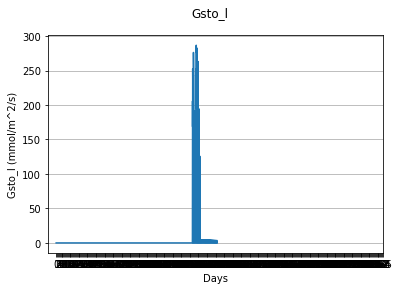

In [20]:
overrides = {
    # We can provide a number of overrides here if needed.
    # Most changes should be done in the configuration file to 
    # ensure reproducability
    "start_day": 1,
    "end_day": 180,
}
# TODO: We should load these iteratively
config_file_name=Path("multiplicative.json")
input_file_name=Path("cell1.csv")

config_file_path=Path(f'{DIRECTORY}/configs/{config_file_name}')
data_file_path=Path(f'{DIRECTORY}/inputs/{input_file_name}')
output_directory_path=Path(f'{DIRECTORY}/outputs/{config_file_name.stem}/{input_file_name.stem}')
output_fields_to_graph=["gsto_l"]
runid="DEMO"
runnotes="""This run is just to demo the model setup.

It was ran using the notebook run_model.ipynb

"""

# The below will run the full do3se model and save the outputs to the output_directory
pyDO3SE_main(
    config_file_path, # Path to the configuration file
    data_file_path, # Path to the data file
    output_directory_path, # Location to save outputs
    output_fields=output_fields_to_graph, # fields to graph. Note we currently output all fields regardless
    runid=runid, # A unique run Id do differentiate between outputs
    runnotes=runnotes, # Stored with the outputs
    **overrides,
)

In [21]:
from pyDO3SE.Output.run_comparisons import create_comparison_graphs



====== Collecting files in examples/multirun/outputs ======

Found the following outputs 
 ['config_b-cell1', 'config_b-cell2', 'multiplicative_thermal_f_phen-pyDO3SE_output_0', 'simple-pyDO3SE_output_0', 'cell1-pyDO3SE_output_DEMO', 'config_a-cell1', 'config_a-cell2']


====== Preparing data ======

config_b  | File:  cell1.csv
config_b  | File:  cell2.csv
multiplicative_thermal_f_phen  | File:  pyDO3SE_output_0.csv
simple  | File:  pyDO3SE_output_0.csv
cell1  | File:  pyDO3SE_output_DEMO.csv
config_a  | File:  cell1.csv
config_a  | File:  cell2.csv


===== Printing Graphs ===== 

== Generating graph for gsto_l

/home/ubu/source/DO3SE/pyDO3SE/pyDO3SE/Analysis/charts.py:215: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
Output saved to gsto_l-4.10.11
== Generating graph for gsto_bulk

Output saved to gsto_bulk-4.10.11
Outputs saved to examples/multirun/comparisons


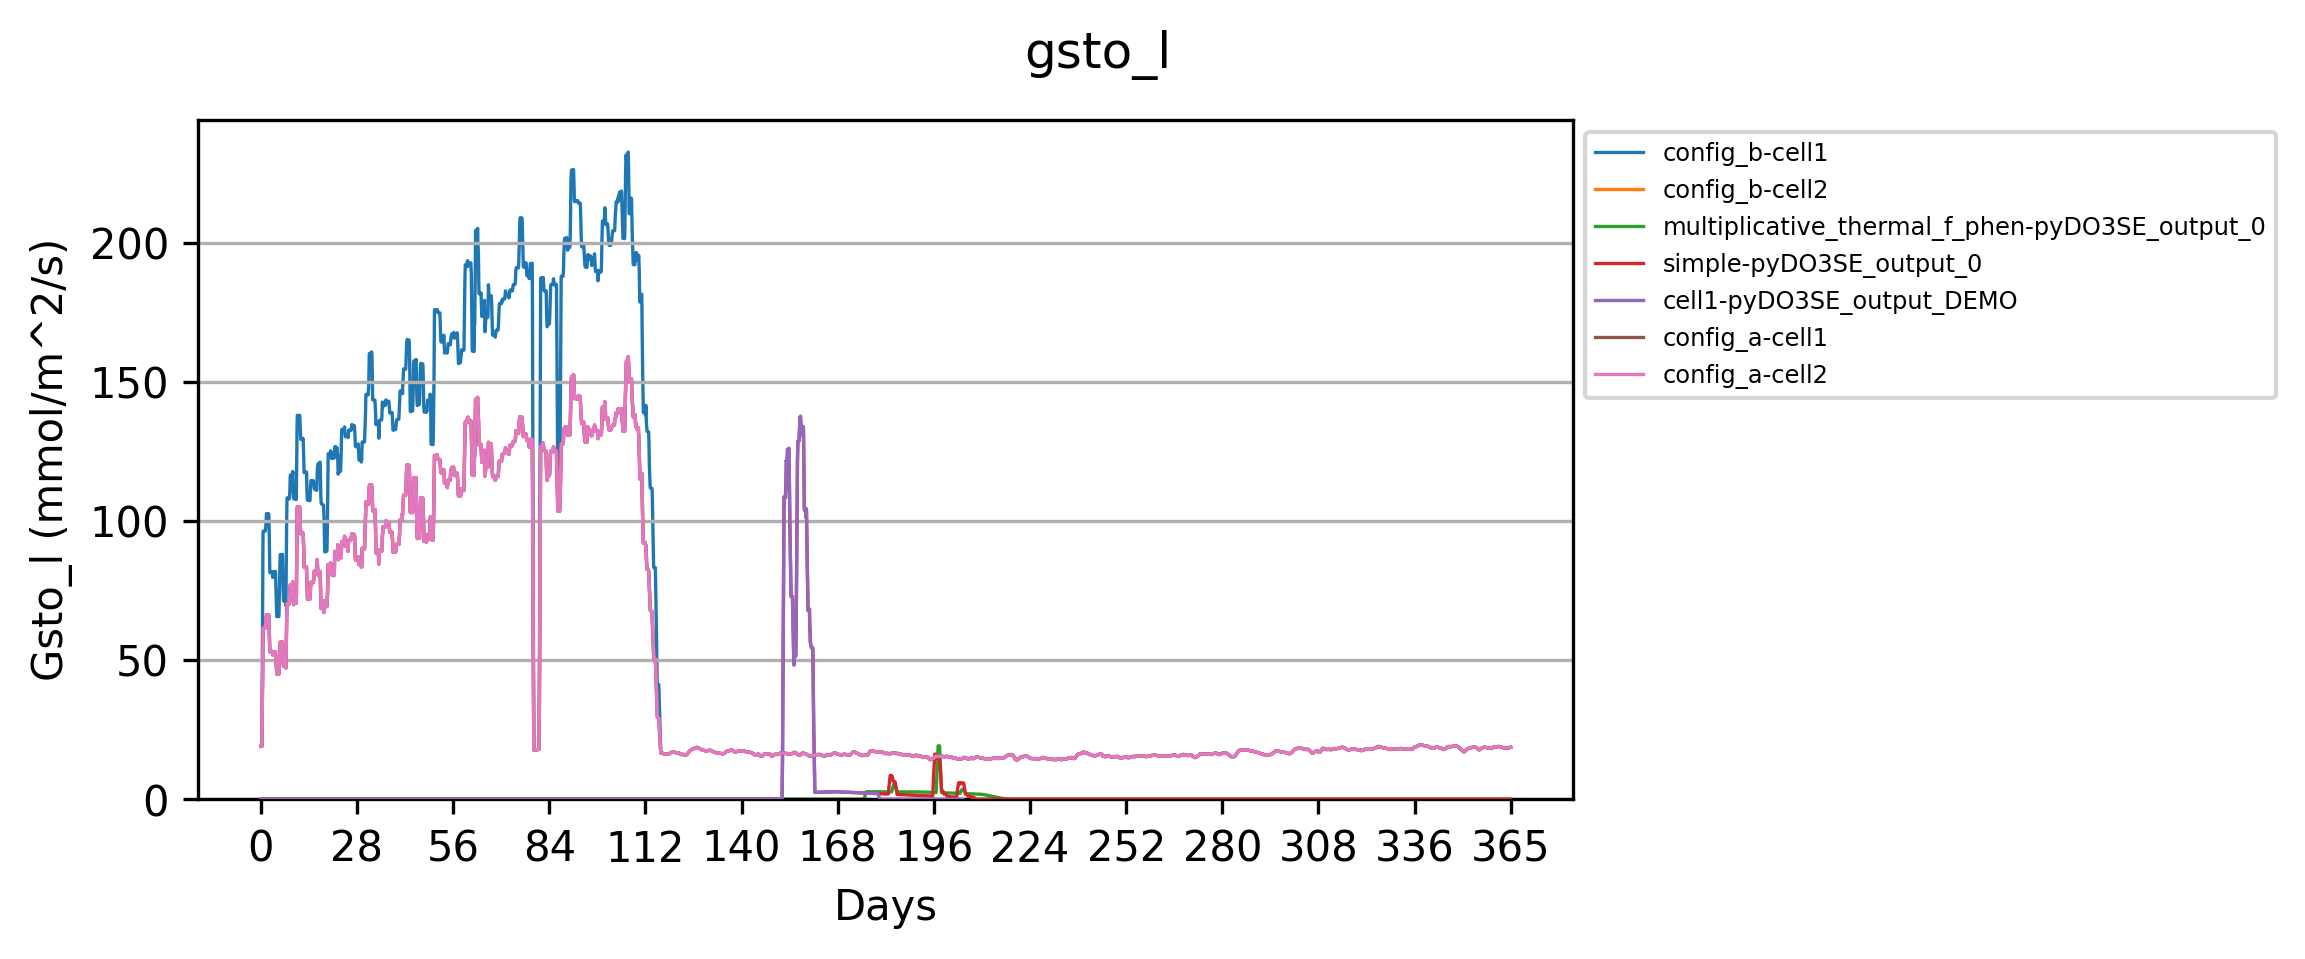

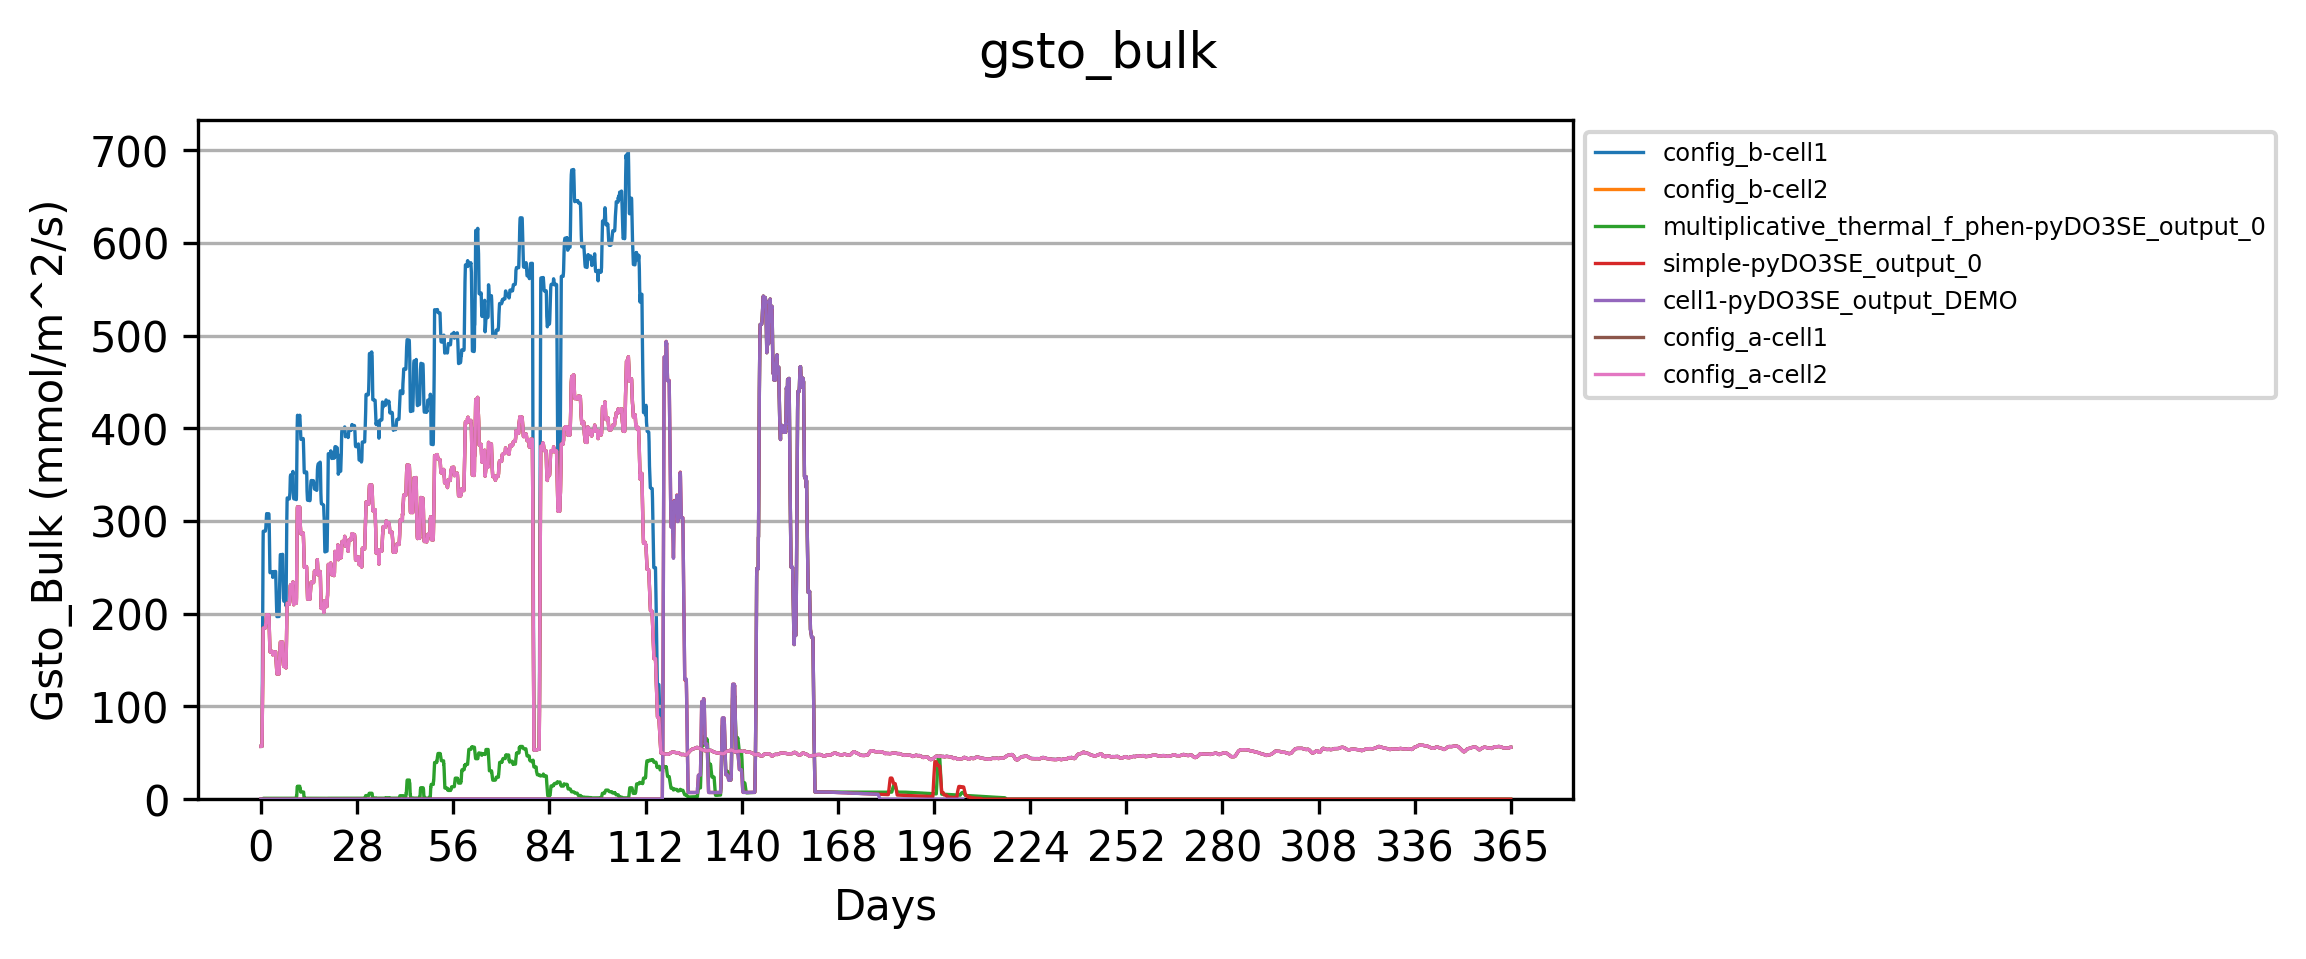

In [22]:
DIRECTORY = "examples/multirun" # Change this to run on a differeny directory
fields_to_graph = ['gsto_l', 'gsto_bulk']
create_comparison_graphs(f'{DIRECTORY}/outputs',fields_to_graph, f'{DIRECTORY}/comparisons', use_versioned_outdir=False)